In [178]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import boxcox

In [179]:
df = pd.read_csv("../data/raw/mbajk_dataset.csv")
df.head()

,Unnamed: 0,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.0,0.0,984.3,22,8
1,1,2023-06-25 20:25:41+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8
2,2,2023-06-25 20:12:20+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,12
3,3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,7
4,4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8


In [180]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [181]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by="date", inplace=True)

In [182]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.0,0.0,984.3,22,8
3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,7
5,2023-06-25 19:45:44+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,6
4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8
6,2023-06-25 20:02:16+00:00,24.2,43,10.9,23.3,0.0,NaN,984.5,22,12


In [183]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y)
    plt.title(f"{y} over time")
    plt.show()

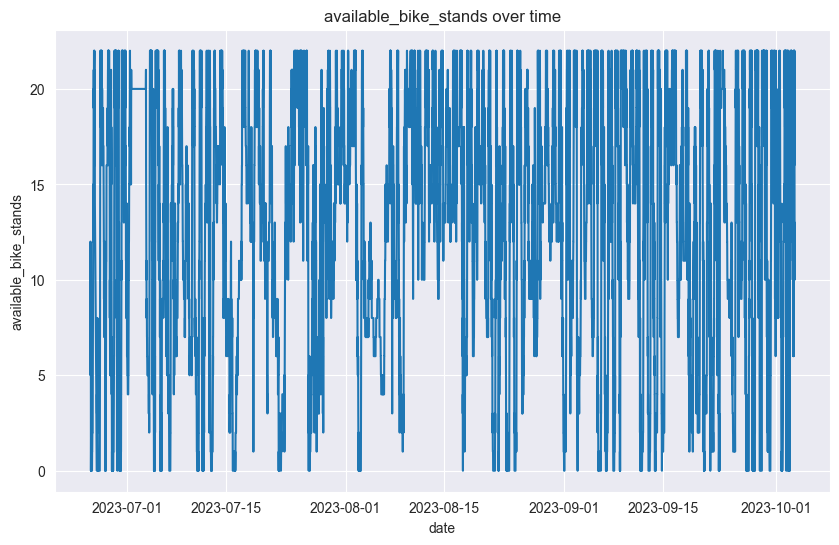

In [184]:
plot_values("date", "available_bike_stands")

In [185]:
df.isnull().sum()

date                            0
temperature                  1869
relative_humidity               0
dew_point                       0
apparent_temperature            0
precipitation_probability    1308
rain                         2804
surface_pressure                0
bike_stands                     0
available_bike_stands           0
dtype: int64

In [186]:
columns_to_fill = df.columns[df.isnull().any()].tolist()

In [187]:
for col in columns_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    features = [c for c in df.columns if c != col and c != 'date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = RandomForestRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [188]:
df.isnull().sum()

date                         0
temperature                  0
relative_humidity            0
dew_point                    0
apparent_temperature         0
precipitation_probability    0
rain                         0
surface_pressure             0
bike_stands                  0
available_bike_stands        0
dtype: int64

In [189]:
df["weekend"] = df["date"].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)
df["is_day"] = df["date"].apply(lambda x: 1 if 6 <= x.hour <= 18 else 0)
df["season"] = df["date"].apply(lambda x: (x.month % 12 + 3) // 3)

In [190]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands,weekend,is_day,season
0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.0,0.0,984.3,22,8,1,0,3
3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,7,1,0,3
5,2023-06-25 19:45:44+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,6,1,0,3
4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,8,1,0,3
6,2023-06-25 20:02:16+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,12,1,0,3


In [191]:
target = "available_bike_stands"

input_cols = df.columns.tolist()
input_cols.remove(target)
input_cols.remove("date")

information_gain = mutual_info_regression(df[input_cols], df[target])

feature_importance = pd.Series(information_gain, index=input_cols)
feature_importance.name = "Information Gain Scores"
feature_importance.sort_values(ascending=False, inplace=True)

<Axes: >

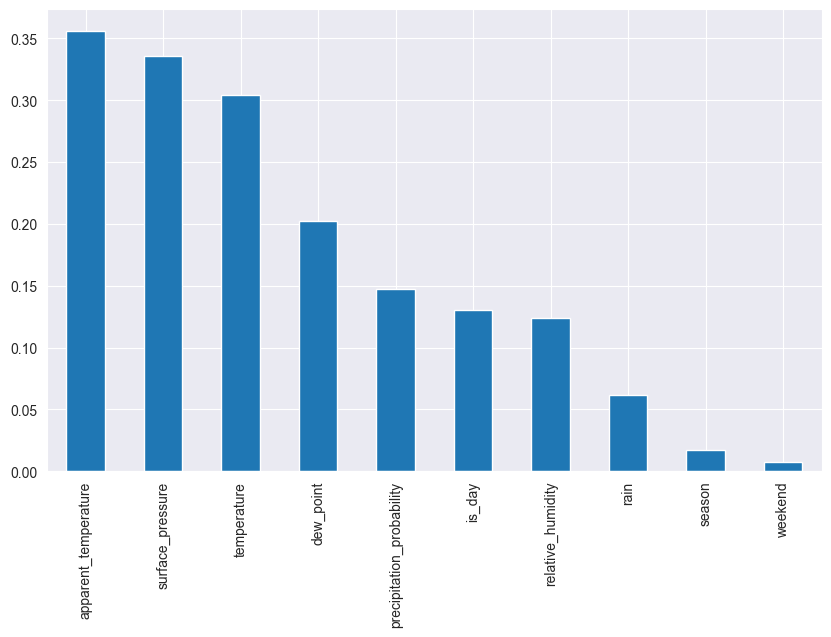

In [192]:
feature_importance.head(10).plot(kind="bar", figsize=(10, 6))

In [193]:
top_features = feature_importance.head(4).index.tolist()
print(top_features)

['apparent_temperature', 'surface_pressure', 'temperature', 'dew_point']


In [194]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Before Box-Cox
    sns.histplot(df[column], ax=ax[0], kde=True)
    ax[0].set_title("Before Box-Cox")

    # transform data
    data, _ = boxcox(df[column])

    # After Box-Cox
    sns.histplot(data, ax=ax[1], kde=True)
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()

In [195]:
# for feature in top_features:
#     boxcox_transform(feature)
# causes RuntimeWarning: overflow encountered in divide X /= self.scale_ when inverse_transforming

In [196]:
features = [target] + top_features + ["date"]
processed_df = df[features]

In [197]:
processed_df.to_csv("../data/processed/mbajk_processed.csv", index=False)